<a href="https://colab.research.google.com/github/ElanaPearl/protein_language_model_primer_demo/blob/main/Protein_Language_Model_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Protein Language Model Demo

This Colab accompanies the paper "Primer on Language Models for Biological Research". Here, we demonstrate the three methods of applying a pre-trained language model to downstream applications:

1. Direct Prediction

2. Embedding

3. Transfer Learning

This Colab illustrates these methods in the context of a protein language model (ESM2), but the general methodologies apply across any natural language or biological language model.

The code below was adapted from https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb

# Setup

We start with a bit of setup, including installing dependencies, importing packages, loading data, and loading models.

## Install dependencies

In [ ]:
!pip install datasets evaluate fair-esm pandas torch transformers[torch] umap-learn xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=83f04616d038c7d801277236b6e6a9d27f0c65329a0c32a73a4b3189535cb59e
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b586

## Import packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from esm import ESM2, Alphabet, BatchConverter
from esm.pretrained import esm2_t6_8M_UR50D
from evaluate import load
from time import time
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from tqdm import trange
from umap import UMAP
from xgboost import XGBClassifier

# Load data

For this demo, we use a simple dataset of proteins that are labeled as localizing either in the cytosol (label = 0) or in the membrane (label = 1).

TODO: figure out how to upload data - put this on GitHub along with colab

In [ ]:
# Load train and test sets and randomly sample 50 sequences from each
n_sample = 50
train = pd.read_csv("membrane_vs_cytosol_train.csv").sample(n=n_sample, replace=False)
test = pd.read_csv("membrane_vs_cytosol_test.csv").sample(n=n_sample, replace=False)

In [ ]:
# Extract lists of sequences and cytosol/membrane labels
train_sequences = train["sequences"].tolist()
train_labels = train["labels"].tolist()

test_sequences = test["sequences"].tolist()
test_labels = test["labels"].tolist()

In [ ]:
# Combine train and test sequences/labels for some downstream applications
sequences = train_sequences + test_sequences
labels = np.array(train_labels + test_labels)

## Load model

Here, we load the smallest ESM2 model, which is a 6-layer Transformer with 8 million parameters. If you want to use a different model, import it from `esm.pretrained` above and call it here instead of `esm2_t6_8M_UR50D`

In [ ]:
# Load model and associated objects
model, alphabet = esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

# Define the final layer of the model
final_layer = 6

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


# Method #1: Direct Prediction

The direct prediction method uses the pre-trained model as is (without any additional training) to make predictions.

For a protein language model like ESM2, the model predicts an output for each amino acid in the protein sequence. This output is the predicted probability that each of the 20 possible amino acids would be found at this position. The direct prediction method can either use these probabilities, or it can use the most probable ("predicted") amino acid at each position, depending on the application.

Below, we are interested in determining whether a single point mutation to a protein sequence is pathogenic or benign. There are multiple ways to use a protein language model for this task. In this tutorial, we approach this by masking$^*$ out the position we are interested in and then querying ESM2 for the probabilities of the wildtype and mutant amino acids at that position. Calculating the log likelihood ratio, `log(prob(mutant) / prob(wildtype))`, gives the relative likelihood of the mutant form compared to the wildtype form. Prior work has shown that these likelihood ratios are predictive of mutation effect and pathogenicity (https://www.biorxiv.org/content/10.1101/2021.07.09.450648v2, https://www.nature.com/articles/s41588-023-01465-0).

$^*$See tutorial for definition and details on masking in languge models.

In [ ]:
# Define a function to run ESM2 and compute probabilities
def get_esm_probabilities(
    model: ESM2,
    batch_converter: BatchConverter,
    sequences: list[str],
    batch_size: int = 2
) -> torch.FloatTensor:
    """Given amino acid sequences, uses an ESM2 model to compute the probability
    of each amino acid at each position in each sequence.

    :param model: A pre-trained ESM2 model.
    :param batch_converter: An ESM2 batch converter.
    :param sequences: A list of protein sequences.
    :param batch_size: The batch size (# of protein sequences per batch).
    :return: A Torch FloatTensor of size (num_sequences, sequence_length, num_amino_acids)
      containing the probability of each amino acid at each position in each sequence.
    """
    # Convert protein sequences to (name, sequence) format expected by ESM2
    name_sequences = [(f"protein_{i}", sequence) for i, sequence in enumerate(sequences)]

    # Set up list to store computed probabilities
    all_sequence_probabilities = []

    # Make probability predictions on all sequences
    with torch.no_grad():
        # Iterate over batches of sequences
        for i in trange(0, len(name_sequences), batch_size):
            # Extract batch data
            batch_name_sequences = name_sequences[i:i + batch_size]

            # Convert batch data to ESM2 format
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_name_sequences)

            # Compute logits for the sequences
            logits = model(batch_tokens, return_contacts=False)["logits"]

            # Apply softmax to get amino acid probabilities
            probabilities = torch.softmax(logits, dim=-1)

            # Save probabilities
            all_sequence_probabilities.append(probabilities)

    # Concatenate probabilities across batches
    all_sequence_probabilities = torch.cat(all_sequence_probabilities)

    return all_sequence_probabilities

In [ ]:
# Select a protein sequence
original_sequence = train_sequences[0]

# Choose a position to analyze
mask_index = 3

# Replace the chosen amino acid with a mask token
masked_sequence = original_sequence[:mask_index] + "<mask>" + original_sequence[mask_index + 1:]

In [ ]:
# Compute ESM probabilities for the masked sequence
all_probs = get_esm_probabilities(
    model=model,
    batch_converter=batch_converter,
    sequences=[masked_sequence]
)

# Extract probabilities for the first sequence as we only passed in one

protein_probs = all_probs[0]

100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Note that the final output is 126 (length of the protein sequence) by 33 (number of possible amino acid tokens). This includes a few non-standard amino acids (X,B,U,Z,O), some gap/deletions tokens (., -) and other tokens useful for training (e.g. sequence padding, start and end of sequences, etc.). For more information on these tokens feel free to explore the attributes in the `alphabet` object

In [ ]:
print()
print(protein_probs.shape)


torch.Size([224, 33])


Now we find the position within the 33 possible amino acids that corresponds to our wild-type (wt) amino acid, the one that was original present in our sequence. Then we compare the model's output for all other amino acids against that one. In this case, our wt amino acid is Serine, and we observe that the LLR for Serine compared to itself is 0 (as we'd expect because this is a _log_ ratio), most possible mutations are deleterious, and a few are even considered slightly beneficial.

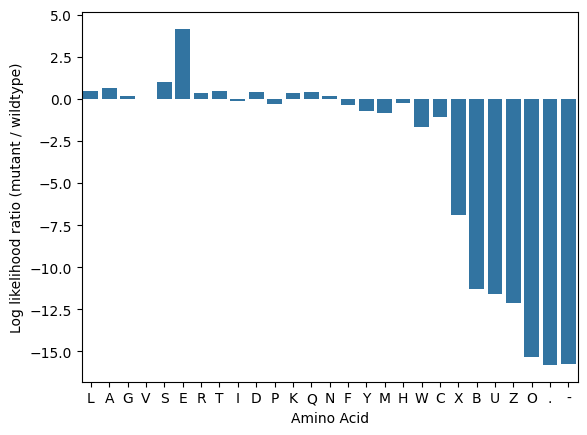

In [ ]:
# Identify token index for wt amino acid
wildtype_amino_acid = original_sequence[mask_index]
wildtype_amino_acid_index = alphabet.tok_to_idx[wildtype_amino_acid]

# For each amino acid in the list of 'standard tokens', calculate LLR against wt
mutant_llr_ratios = []
for character in alphabet.standard_toks:
  mutant_amino_acid_index = alphabet.tok_to_idx[character]

  mutant_llr_ratios.append(torch.log(
    protein_probs[mask_index, mutant_amino_acid_index] /
    protein_probs[mask_index, wildtype_amino_acid_index]
  ).item())

# Plot results
f = sns.barplot(mutant_llr_ratios)
f.set_xticks(range(len(mutant_llr_ratios)))
f.set_xticklabels(alphabet.standard_toks)
plt.xlabel("Amino Acid")
plt.ylabel("Log likelihood ratio (mutant / wildtype)")
plt.show()

# Method #2: Embedding

The embedding, like the direct prediction method, uses the pre-trained model as is (without any additional training). However, rather than obtaining probability or token predictions, the embedding method uses the embeddings (an internal numerical representation) of the protein sequences computed by the model for downstream analyses such as visualization and clustering.

Below, we are interested in visualizing the embeddings of protein sequences computed by ESM2 to determine if they can characterize the localization (cytosol or membrane) of proteins. We will first embed all of our protein sequences, by passing the sequences (with no masks) through the model and extracting the internal representation. There are multiple layers at which an embedding _could_ be extracted, here we use the final layer of the model.

These embeddings are originally high dimensional (e.g. in the model used here, each sequence is represented by a list of 320 numbers). In order easily visualize them, we must reduce this dimension, so we apply a UMAP to reduce the embeddings to 2 dimensions. Finally we will plot the 2-dimensional embeddings and color-code them by protein localization to see whether any patterns emerge.

In [ ]:
def generate_esm_embeddings(
        model: ESM2,
        batch_converter: BatchConverter,
        sequences: list[str],
        embedding_layer: int,
        average_embeddings: bool = False,
        batch_size: int = 2
) -> torch.FloatTensor:
    """Generate embeddings of protein sequences using an ESM2 model.

    :param model: A pre-trained ESM2 model.
    :param batch_converter: An ESM2 batch converter.
    :param sequences: A list of tuples of (name, sequence) for the proteins.
    :param embedding_layer: Layer of the ESM2 model from which to will extract embeddings.
    :param average_embeddings: Whether to average the residue embeddings for each protein.
    :param batch_size: The batch size (# of protein sequences per batch).
    :return: A Torch FloatTensor of sequence embeddings.
      If average_embeddings=True, size is (num_sequences, embedding_size).
      If average_embeddings=False, size is (num_sequences, sequence_length, embedding_size).
    """
    # Convert protein sequences to (name, sequence) format expected by ESM2
    name_sequences = [(f"protein_{i}", sequence) for i, sequence in enumerate(sequences)]

    # Set up list to store computed embeddings
    embeddings = []

    # Make probability predictions on all sequences
    with torch.no_grad():
        # Iterate over batches of sequences
        for i in trange(0, len(sequences), batch_size):
            # Extract batch data
            batch_name_sequences = name_sequences[i:i + batch_size]

            # Convert batch data to ESM2 format
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_name_sequences)

            # Calculate the length of each sequence in a batch
            batch_lengths = (batch_tokens != alphabet.padding_idx).sum(1)

            # Subtract 2 from each to remove start and end tokens
            batch_lengths -= 2

            # Compute embeddings for the sequences
            results = model(batch_tokens, repr_layers=[embedding_layer], return_contacts=False)

            # Get per-amino acid embeddings for the selected layer
            batch_embeddings = results['representations'][embedding_layer]

            # Extract embeddings and optionally average across the sequence
            for (name, _,), embedding, sequence_len in zip(batch_name_sequences, batch_embeddings, batch_lengths):
                # Extract embeddings for amino acids without start, end, or pad tokens
                embedding = embedding[1 : sequence_len + 1]

                # Optionally, average embeddings across amino acids in the sequence
                if average_embeddings:
                    embedding = embedding.mean(dim=0)

                # Save embeddings
                embeddings.append(embedding)

    # Stack embeddings across sequences
    embeddings = torch.stack(embeddings)

    return embeddings

In [ ]:
# Compute embeddings for all sequences (with averaging to give a single embedding per sequence)
embeddings = generate_esm_embeddings(
    model=model,
    batch_converter=batch_converter,
    sequences=sequences,
    embedding_layer=final_layer,
    average_embeddings=True
)

100%|██████████| 50/50 [00:39<00:00,  1.25it/s]


We see the embeddings have a shape of 100 (number of sequences) x 320 (embedding dimension). This embedding dimension depends on your model of choice

In [ ]:
print(embeddings.shape)

torch.Size([100, 320])


In [ ]:
# Apply UMAP to reduce the embeddings to two dimensions
embeddings_2d = UMAP().fit_transform(embeddings)

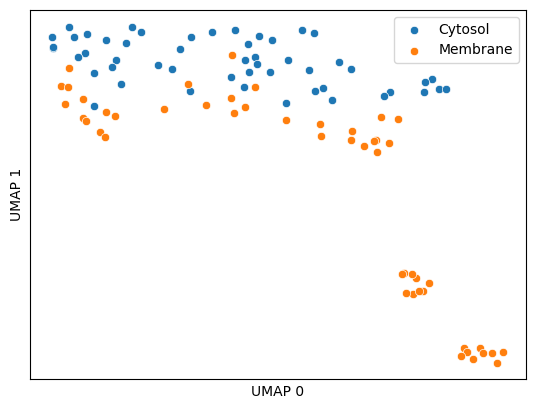

In [ ]:
# Plot the UMAP of embeddings, colored by cytosol/membrane label
sns.scatterplot(
    x=embeddings_2d[labels == 0, 0],
    y=embeddings_2d[labels == 0, 1],
    label="Cytosol"
)
sns.scatterplot(
    x=embeddings_2d[labels == 1, 0],
    y=embeddings_2d[labels == 1, 1],
    label="Membrane"
)

plt.xlabel("UMAP 0")
plt.ylabel("UMAP 1")

plt.xticks([])
plt.yticks([])

plt.legend()

plt.show()

# Method #3: Transfer Learning

The transfer learning method starts with the pre-trained language model but applies additional training to adapt the model to a particular downstream application.

There are two general techniques for applying transfer learning.

1. **Embed & Train:** Given limited data and compute, one transfer learning approach is to use the pre-trained model to compute embeddings for each sequence and then train a separate, typically smaller, model to predict the downstream task from those embeddings.

TODO: do we want to use this "Embed & Train" terminology in the paper/figures? Maybe adapter layers? Or "train on embeddings"

2. **Fine-Tune:** Given sufficient data and compute, another transfer learning method is to fine-tune (further train) the language model itself. This could involve fine-tuning some or all of the layers of the model.

Below, we demonstrate both transfer learning techniques for predicting protein localization

## Method 3-1: Embed & Train

Using the Embed & Train technique for transfer learning, we will use the protein sequence embeddings we previously computed in Method 2 and train a small XGBoost model with those embeddings as input to predict protein localization.

In [ ]:
# Load a function to compute accuracy
accuracy = load("accuracy")

In [ ]:
# Separate the embeddings into train and test
train_embeddings = embeddings[:len(train_sequences)]
test_embeddings = embeddings[len(train_sequences):]

In [ ]:
# Train an XGB classifier on the training data (embeddings and labels)
xgb_model = XGBClassifier().fit(train_embeddings, train_labels)

In [ ]:
# Use the trained XGB classifier to make predictions on the test data
test_preds = xgb_model.predict(test_embeddings)

In [ ]:
# Evaluate the XGB test predictions
print(f"XGB test accuracy = {accuracy.compute(predictions=test_preds, references=test_labels)}")

XGB test accuracy = {'accuracy': 0.88}


## Method 3-2: Fine-Tune

Using the Fine-Tune technique for transfer learning, we will fine-tune the entire ESM2 model to predict protein localization.

Since our protein localization model requires a classification layer at the end of the model, we will load the ESM2 model using an alternate mechanism that replaces the final layer of the model (which typically predicts an amino acid _per position_ of the sequence) with a classification layer that predicts 1 value _per sequence_.

In [ ]:
# Specify the ESM2 model
model_name = "esm2_t6_8M_UR50D"
model_checkpoint = f"facebook/{model_name}"

When fine-tuning we need to explicitely define our _tokenizer_. A tokenizer turns a protein representation from a sequence of strings into a sequence of "tokens" (integer numbers) that can be fed into the network. In the earlier example, the tokenization process is abstracted away but here we must run it manually.

In [ ]:
# Load a tokenizer that converts amino acids into the format expected by ESM2
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# Load the ESM2 model
# Note: Ignore warnings some weights not being initialized since we need this for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the train and test sequences
train_tokenized = tokenizer(train["sequences"].tolist())
test_tokenized = tokenizer(test["sequences"].tolist())

In [ ]:
# Convert the train and test sequences into a Dataset object
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

In [ ]:
# Add labels to the train and test datasets
train_dataset = train_dataset.add_column("labels", train["labels"].tolist())
test_dataset = test_dataset.add_column("labels", test["labels"].tolist())

In [ ]:
# Define the ESM2 training arguments
args = TrainingArguments(
    f"{model_name}-finetuned-localization",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

In [ ]:
def compute_accuracy(eval_pred: tuple[np.ndarray, np.ndarray]) -> float:
    """Computes the accuracy of predictions.

    :param eval_pred: A tuple of NumPy arrays containing an array of predictions
      and an array of labels.
    :return: The accuracy of the predictions.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# Set up the Trainer for training the ESM2 model
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
# Fine-tune the ESM2 model and evaluate prediction accuracy
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.658258,0.700000
2,No log,0.608560,0.880000
3,No log,0.587803,0.880000


TrainOutput(global_step=75, training_loss=0.6237006632486979, metrics={'train_runtime': 118.8416, 'train_samples_per_second': 1.262, 'train_steps_per_second': 0.631, 'total_flos': 2195831161632.0, 'train_loss': 0.6237006632486979, 'epoch': 3.0})